In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data = pd.read_csv('seleb_non_none.csv')
data.head()

,path,split,class_label,spoof_type,illumination_condition,environment
0,train/1/live/000184.jpg,train,0,0.0,0.0,0.0
1,train/1/live/032887.jpg,train,0,0.0,0.0,0.0
2,train/1/live/059151.jpg,train,0,0.0,0.0,0.0
3,train/1/live/072342.jpg,train,0,0.0,0.0,0.0
4,train/1/live/072393.jpg,train,0,0.0,0.0,0.0


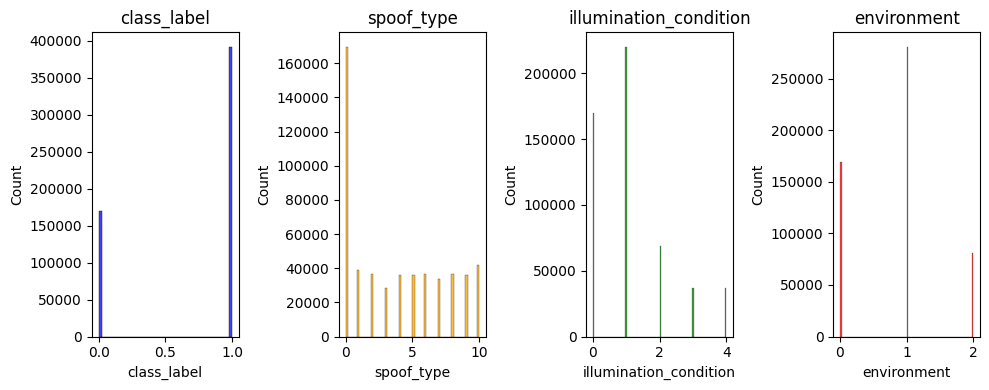

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))

sns.histplot(data['class_label'], ax=axs[0], color='blue')
axs[0].set_title('class_label')

sns.histplot(data['spoof_type'], ax=axs[1], color='orange')
axs[1].set_title('spoof_type')

sns.histplot(data['illumination_condition'], ax=axs[2], color='green')
axs[2].set_title('illumination_condition')

sns.histplot(data['environment'], ax=axs[3], color='red')
axs[3].set_title('environment')

# Настройка общего оформления
plt.tight_layout()
plt.show()

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561575 entries, 0 to 561574
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   path                    561575 non-null  object 
 1   split                   561575 non-null  object 
 2   class_label             561575 non-null  int64  
 3   spoof_type              531511 non-null  float64
 4   illumination_condition  531511 non-null  float64
 5   environment             531511 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 25.7+ MB


In [26]:
data[data['spoof_type'].isna()]

,path,split,class_label,spoof_type,illumination_condition,environment
10621,train/10170/spoof/018135.jpg,train,1,NaN,NaN,NaN
10622,train/10170/spoof/020922.jpg,train,1,NaN,NaN,NaN
10623,train/10170/spoof/022517.jpg,train,1,NaN,NaN,NaN
10625,train/10170/spoof/025744.jpg,train,1,NaN,NaN,NaN
10626,train/10170/spoof/028551.jpg,train,1,NaN,NaN,NaN
...,...,...,...,...,...,...
544460,test/8589/live/548411.png,test,1,NaN,NaN,NaN
544461,test/8589/live/550851.png,test,1,NaN,NaN,NaN
544462,test/8605/live/499978.png,test,1,NaN,NaN,NaN
544463,test/8605/live/543031.png,test,1,NaN,NaN,NaN


In [27]:
data= data.dropna()

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531511 entries, 0 to 561574
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   path                    531511 non-null  object 
 1   split                   531511 non-null  object 
 2   class_label             531511 non-null  int64  
 3   spoof_type              531511 non-null  float64
 4   illumination_condition  531511 non-null  float64
 5   environment             531511 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 28.4+ MB


In [28]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import torchvision.transforms as transforms

In [29]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):

        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx]['path'])

        class_label = self.dataframe.iloc[idx]['spoof_type']  
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        return image, class_label
        

In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),         
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [33]:
data_dir = "C:/Users/annam/Documents/Проекты/Диплом/Данные 2/CelebA_Spoof/Data"

train_df = data.loc[data['split']=='train']
test_df = data.loc[data['split']=='test']
print('train:',train_df.shape,'test:',test_df.shape)

train: (467585, 6) test: (63926, 6)


In [34]:
train_dataset = CustomDataset(train_df, root_dir=data_dir, transform=transform)
test_dataset = CustomDataset(test_df, root_dir=data_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [43]:
# Модель
model = create_model("mobilevitv2_175", pretrained=True)

model.final_conv = nn.Identity() 

# Функция для модификации модели
class CustomClassifier(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomClassifier, self).__init__()
        self.base_model = base_model 
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))   
        self.classifier = nn.Linear(896, num_classes)  

    def forward(self, x):
        x = self.base_model.forward_features(x)  
        x = self.global_pool(x)  
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)  
        return x

model = CustomClassifier(base_model=model, num_classes=11)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [44]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [45]:
model

CustomClassifier(
  (base_model): ByobNet(
    (stem): ConvNormAct(
      (conv): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (stages): Sequential(
      (0): Sequential(
        (0): BottleneckBlock(
          (conv1_1x1): ConvNormAct(
            (conv): Conv2d(56, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
          )
          (conv2_kxk): ConvNormAct(
            (conv): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=112, bias=False)
            (bn): BatchNormAct2d(
              112, eps=1e-05, momentum=0.1, affine=True, track_runni

In [46]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, class_labels in dataloader:
            images = images.to(device)
            class_labels = class_labels.to(device).long() 
            
            optimizer.zero_grad()
 
            outputs = model(images)
     
            loss = criterion(outputs, class_labels)
      
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Эпоха {epoch+1}/{num_epochs}, Потеря: {running_loss / len(dataloader):.4f}")
    return model

# Обучение модели
model = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

KeyboardInterrupt: 

In [ ]:
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, class_labels in dataloader:
            images = images.to(device)
            class_labels = class_labels.to(device)

            outputs = model(images)

            # Предсказания
            _, predicted = torch.max(outputs, 1)
            total += class_labels.size(0)
            correct += (predicted == class_labels).sum().item()

    print(f"Точность на тестовых данных: {100 * correct / total:.2f}%")

# Тестируем модель
test_model(model, test_loader)